In [3]:
from collections import Counter
from numpy import NaN, unicode_
import pandas as pd

import requests
import json 
import base64

# TODO: move these into a file/environment variable external to the code
client_ID = "27d9f488070742d2aef19da110262941"
client_secret = "e25970d2f33740a6a49bb06866abf20b"

auth_endpoint = "https://accounts.spotify.com/api/token"
search_API_endpoint = "https://api.spotify.com/v1/search"

# get access token to use for authentication with search api
def get_access_token():
    # from Spotify docs:
    # Required: Base 64 encoded string that contains the client ID and client secret key. 
    # The field must have the format: 
    # Authorization: Basic *<base64 encoded client_id:client_secret>*
    message = client_ID + ":" + client_secret
    message_bytes = message.encode("ascii")
    base64_bytes = base64.b64encode(message_bytes)
    encoded_client_details = base64_bytes.decode("ascii")
    
    headers = {"Authorization": "Basic " + encoded_client_details}              
    body = {"grant_type": "client_credentials"}
    response = requests.post(url=auth_endpoint, headers=headers, data=body)
    json_object = json.loads(response.text)
    return json_object["access_token"]
    
# make the request using requests module
# need to send the access token via request headers
def make_request(access_token, full_url):
    headers = {"Accept": "application/json", 
               "Content-Type": "application/json", 
               "Authorization": "Bearer " + access_token}

    response = requests.get(url=full_url, headers=headers)
    json_object = json.loads(response.text)

    return json_object

# create request url, make request, return JSON response
def search_request(access_token, search_term, search_type):
    search_term = requests.utils.quote(search_term)
    search_type = requests.utils.quote(search_type)
    url = search_API_endpoint + "?q=" + search_term
    url += "&type=" + search_type
    json_obj = make_request(access_token, url)
    return json_obj

# parse list of genres from JSON response
def get_genres(json_obj):
    artists = json_obj["artists"]
    items = artists["items"]
    first_artist_item = items[0] # TODO: are they sorted by match confidence/popularity?
    genres = first_artist_item["genres"]
    return genres

def run_for_art(art_name):
    access_token = get_access_token()
    json_obj = search_request(access_token, art_name, "artist")
    genres = get_genres(json_obj)
    return genres

# creating the data frame
# df0 = pd.read_json("HSStreamingHistory0.json")
# df1 = pd.read_json("HSStreamingHistory1.json")
df2 = pd.read_json("HSStreamingHistory2.json")
df3 = pd.read_json("HSStreamingHistory3.json")


df = pd.concat([df3])

df["endHour"] = df["endTime"].str.split(' ').str[1].str.split(':').str[0].astype(int)
df["date"] = df["endTime"].str.split(' ').str[0]
df = df.drop("endTime", axis=1)
days = pd.read_csv("DaysofWeek.csv")
df = df.merge(days, on=["date"], how="inner")

group_by_day = df.groupby("days of week")
fri_df = group_by_day.get_group("Friday")
sat_df = group_by_day.get_group("Saturday")
sun_df = group_by_day.get_group("Sunday")
mon_df = group_by_day.get_group("Monday")
tue_df = group_by_day.get_group("Tuesday")
wed_df = group_by_day.get_group("Wednesday")
thur_df = group_by_day.get_group("Thursday")

weekday_df = mon_df

weekday_df = weekday_df.append(tue_df)
weekday_df = weekday_df.append(wed_df)
weekday_df = weekday_df.append(thur_df)
weekday_df = weekday_df.append(fri_df)

## first group by date
dates = weekday_df.groupby("date")


HSdf_date = pd.DataFrame()

HSdf_date["date"] = dates.groups.keys()
# HSdf_date["day of week"] = df["days of week"]

mode_art = []
mode_genere = []

for date in HSdf_date["date"]:
    item = dates.get_group(date)["artistName"].mode()[0]
    mode_art.append(item)

HSdf_date["mode artist"] = mode_art

for artist in HSdf_date["mode artist"]:
    if len(run_for_art(artist)) > 0:
        genere = run_for_art(artist)[0]
        mode_genere.append(genere)
    else:
        mode_genere.append(NaN)

HSdf_date["mode genre"] = mode_genere

HSdf_date.drop([6, 47], inplace=True)


LWdf1 = pd.read_json("LWStreamingHistory1.json")
LWdf2 = pd.read_json("LWStreamingHistory2.json")


df = pd.concat([LWdf1, LWdf2])

df["endHour"] = df["endTime"].str.split(' ').str[1].str.split(':').str[0].astype(int)
df["date"] = df["endTime"].str.split(' ').str[0]
df = df.drop("endTime", axis=1)
days = pd.read_csv("DaysofWeek.csv")
df = df.merge(days, on=["date"], how="inner")
df.dropna()

group_by_day = df.groupby("days of week")
fri_df = group_by_day.get_group("Friday")
sat_df = group_by_day.get_group("Saturday")
sun_df = group_by_day.get_group("Sunday")
mon_df = group_by_day.get_group("Monday")
tue_df = group_by_day.get_group("Tuesday")
wed_df = group_by_day.get_group("Wednesday")
thur_df = group_by_day.get_group("Thursday")

weekday_df = mon_df

weekday_df = weekday_df.append(tue_df)
weekday_df = weekday_df.append(wed_df)
weekday_df = weekday_df.append(thur_df)
weekday_df = weekday_df.append(fri_df)

## first group by date
dates = weekday_df.groupby("date")


LWdf_date = pd.DataFrame()

LWdf_date["date"] = dates.groups.keys()
# LWdf_date["day of week"] = df["days of week"]

mode_art = []
mode_genere = []

for date in LWdf_date["date"]:
    item = dates.get_group(date)["artistName"].mode()[0]
    mode_art.append(item)

LWdf_date["mode artist"] = mode_art

for artist in LWdf_date["mode artist"]:
    if len(run_for_art(artist)) > 0:
        genere = run_for_art(artist)[0]
        mode_genere.append(genere)
    else:
        mode_genere.append(NaN)

LWdf_date["mode genre"] = mode_genere


['classical' 'alternative rock' 'baltimore indie' 'hip hop' 'jam band'
 'art pop' 'afrofuturism' 'alternative r&b' 'french indie pop'
 'alternative country' 'electropop' 'baroque' 'french pop' 'ambient folk'
 'pet calming']
m: -2.34035939211393 b: 4573.877314485214
y predicted: [4573.87731449 4571.53695509 4569.1965957  4566.85623631 4564.51587692
 4562.17551752 4559.83515813 4557.49479874 4555.15443935 4552.81407996
 4550.47372056 4548.13336117 4545.79300178 4543.45264239 4541.112283  ]
classical              4573.877314
alternative rock       4571.536955
baltimore indie        4569.196596
hip hop                4566.856236
jam band               4564.515877
art pop                4562.175518
afrofuturism           4559.835158
alternative r&b        4557.494799
french indie pop       4555.154439
alternative country    4552.814080
electropop             4550.473721
baroque                4548.133361
french pop             4545.793002
ambient folk           4543.452642
pet calming      

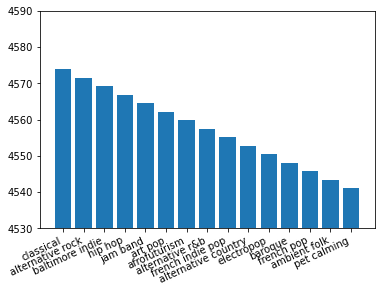

In [11]:
import matplotlib.pyplot as plt
import numpy as np
# print(HSdf_date)

from scipy import stats

stocks = pd.read_csv("stocks.csv")
close_price = stocks["Close"]


X = HSdf_date["mode genre"]
X = X.fillna(method="backfill")
labels = X.unique()




print(labels)

Y = close_price



from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
X = labelencoder.fit_transform(X)



m, b, r, r_pval, std_err = stats.linregress(X, Y)
print("m:", m, "b:", b)


X_train = np.reshape(X, (-1, 1))
y_train = Y
X_test = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12],[13],[14]] 
# print(X)



# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_predicted = lin_reg.predict(X_test)
print("y predicted:", y_predicted)


ser = pd.Series(y_predicted, index=labels)
print(ser)

plt.bar(ser.index,ser.values)
ax = plt.gca()
ax.set_ylim([4530, 4590])
plt.xticks(rotation=25, ha="right")
plt.savefig("HS_genre_stock.png")



['alaska indie' 'alternative r&b' 'indie garage rock' 'indie pop'
 'bedroom pop' 'orlando indie' 'city pop' 'chillhop' 'alt z'
 'alternative metal' 'bedroom soul' 'deep new americana' 'bubblegrunge'
 'dance pop' 'modern indie pop' 'disney' 'indie folk' 'canadian hip hop'
 'big room' 'boy band' 'pop' 'chicago rap' 'atl hip hop' 'acoustic pop']
m: -1.8581215857019424 b: 4588.335373187874
y predicted: [4588.33537319 4586.4772516  4584.61913002 4582.76100843 4580.90288685
 4579.04476526 4577.18664367 4575.32852209 4573.4704005  4571.61227892
 4569.75415733 4567.89603575 4566.03791416 4564.17979257 4562.32167099
 4560.4635494  4558.60542782 4556.74730623 4554.88918465 4553.03106306
 4551.17294147 4549.31481989 4547.4566983  4545.59857672]
alaska indie          4588.335373
alternative r&b       4586.477252
indie garage rock     4584.619130
indie pop             4582.761008
bedroom pop           4580.902887
orlando indie         4579.044765
city pop              4577.186644
chillhop          

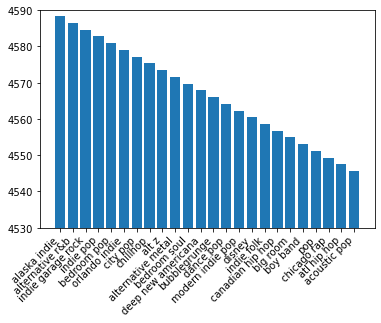

In [12]:
X = LWdf_date["mode genre"]
X = X.fillna(method="backfill")
labels = X.unique()

print(labels)

Y = close_price.head(49)



from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
X = labelencoder.fit_transform(X)



m, b, r, r_pval, std_err = stats.linregress(X, Y)
print("m:", m, "b:", b)


X_train = np.reshape(X, (-1, 1))
y_train = Y
X_test = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12],[13],[14],[15],[16],[17],[18],[19],[20],[21],[22],[23]] 
# print(X)



# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_predicted = lin_reg.predict(X_test)
print("y predicted:", y_predicted)


ser = pd.Series(y_predicted, index=labels)
print(ser)

plt.bar(ser.index,ser.values)
ax = plt.gca()
ax.set_ylim([4530, 4590])
plt.xticks(rotation=45, ha="right")
plt.savefig("LW_genre_stock.png")

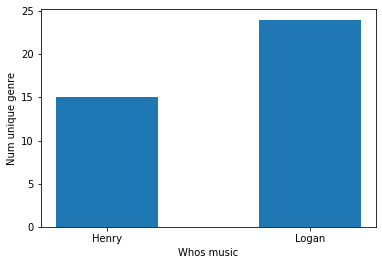

In [7]:
plt.figure()
plt.bar(["Henry","Logan"], [len(HSdf_date["mode genre"].value_counts()), len(LWdf_date["mode genre"].value_counts())], width=0.5)
plt.xlabel("Whos music")
plt.ylabel("Num unique genre")
plt.savefig("unique_genre_bar.png")